In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, UpSampling1D, Conv2DTranspose, MaxPool1D, Dropout, Conv1D, Conv2D, Conv3D, Flatten, MaxPool2D, AveragePooling2D, BatchNormalization


In [2]:
im = imread('../data/denoising/saturn.png')
noise1 = imread('../data/denoising/saturn-noisy.png')
error1 = ((im - noise1)**2).sum()
print ('Noisy image SE: {:.2f}'.format(error1))

Noisy image SE: 361.80


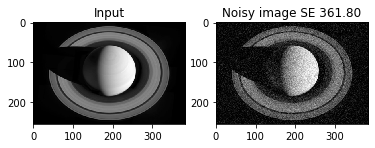

In [3]:
plt.figure(1)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Input')

plt.subplot(122)
plt.imshow(noise1, cmap='gray')
plt.title('Noisy image SE {:.2f}'.format(error1))

plt.show(block=False)

In [4]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1) # Encoder - 4
        self.conv5 = nn.Conv2d(128, 256, 3, 2, 1) # Encoder - 5
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv5_t = nn.Conv2d(256, 256, 3, 1, 1) # Decoder - 5
        self.conv4_t = nn.Conv2d(256, 128, 3, 1, 1) # Decoder - 4
        self.conv3_t = nn.Conv2d(128, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.bn128(F.relu(self.conv4(out)))
        out = self.bn256(F.relu(self.conv5(out)))
        out = self.upsample(self.bn256(F.relu(self.conv5_t(out))))
        out = self.upsample(self.bn128(F.relu(self.conv4_t(out))))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

In [5]:
MAX_EPOCHS = 5000

net = EncDec()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.41598859429359436, Error = 40893.34372075079
Loss = 0.004273304250091314, Error = 420.0828802319693
Loss = 0.002539675449952483, Error = 249.6602481614521
Loss = 0.0017688320949673653, Error = 173.88327388274374
Loss = 0.0013685410376638174, Error = 134.53305748557486
Loss = 0.001203213119879365, Error = 118.28066036120116
Loss = 0.0011065320577472448, Error = 108.77652940927022
Loss = 0.001126984367147088, Error = 110.7870695037003
Loss = 0.001021609758026898, Error = 100.42832538041776
Loss = 0.0008949942421168089, Error = 87.98151417169365
Loss = 0.0006754786591045558, Error = 66.40225235271743
Loss = 0.0006011692457832396, Error = 59.09734244075074
Loss = 0.0005650152452290058, Error = 55.54325702879994
Loss = 0.0004961437662132084, Error = 48.772914433160224
Loss = 0.00044454593444243073, Error = 43.700642880712905
Loss = 0.0005199474981054664, Error = 51.11292020364058
Loss = 0.00039306178223341703, Error = 38.639544042754444
Loss = 0.0005010340246371925, Error = 49.2536

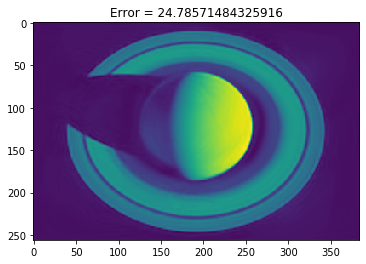

In [6]:
plt.imshow(out_img)
plt.title('Error = {}'.format(curr_error))
plt.show()

In [7]:
# Loss = 0.33063435554504395, Error = 32502.678978232478
# Loss = 0.003678500186651945, Error = 361.6112777204725
# Loss = 0.002491388702765107, Error = 244.9134742561787
# Loss = 0.0021309664007276297, Error = 209.48252337746322
# Loss = 0.0019235952058807015, Error = 189.09710513352672
# Loss = 0.0017378574702888727, Error = 170.8383374439931
# Loss = 0.0016195819480344653, Error = 159.2113847145719
# Loss = 0.001625651610083878, Error = 159.8080514887506
# Loss = 0.001578581752255559, Error = 155.18089973912902
# Loss = 0.0014895866625010967, Error = 146.43232328237613
# Loss = 0.0014551874483004212, Error = 143.0507453758675
# Loss = 0.0014207038329914212, Error = 139.66086999732352
# Loss = 0.0014441290404647589, Error = 141.96365904241804
# Loss = 0.0013894528383389115, Error = 136.58876693758225
# Loss = 0.0013061281060799956, Error = 128.39761212615383
# Loss = 0.00129575130995363, Error = 127.37753981561679
# Loss = 0.0012875754619017243, Error = 126.57381866931212
# Loss = 0.001300361123867333, Error = 127.83069425872246
# Loss = 0.0012997257290408015, Error = 127.76823847838075
# Loss = 0.0012404872104525566, Error = 121.94485366447556